In [1]:
# Import modules 
import os
import string
from utils import model_utils
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from pickle import dump, load

# Decoder model imports
import numpy as np
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from numpy import array, prod
from keras.callbacks import ModelCheckpoint

#plot curve
import matplotlib.pyplot as plt
%inline matplotlib

Using TensorFlow backend.
D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\ProgramFiles\Anaconda3\envs\keras_tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\ProgramFiles\Anacond

In [2]:
# File split for train, test and validation
if not ((os.path.exists('train.pkl')) and (os.path.exists('valid.pkl')) and (os.path.exists('test.pkl'))):
    train_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.devImages.txt'
    test_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.trainImages.txt'
    valid_path = r'..\Flickr8k\Flickr8k_text\Flickr_8k.testImages.txt'
    paths = []
    for path in [train_path, valid_path, test_path]:
        with open(path, 'r') as fh:
            paths = paths + fh.readlines()
    sample_idx = np.random.choice(len(paths), size=int(len(paths)), replace=False)

    # Train Set 80% of the data
    train_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[:int(len(sample_idx)*.80)]]
    valid_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[int(len(sample_idx)*.80):int(len(sample_idx)*.90)]]
    test_set = [paths[idx].strip('\n').split('.')[0] for idx in sample_idx[int(len(sample_idx)*.90):]]
    dump(train_set, open('train.pkl', 'wb'))
    dump(valid_set, open('valid.pkl', 'wb'))
    dump(test_set, open('test.pkl', 'wb'))
else:
    train_set = load(open('train.pkl', 'rb'))
    valid_set = load(open('valid.pkl', 'rb')) 
    test_set = load(open('test.pkl', 'rb'))

In [3]:
def initiate_encoder(arch='capsnet'):
    """
        Description: Initiate the encoder 
        :arch: 'capsnet' or 'vgg'
    """
    if arch=='capsnet':
        encoder_model = model_utils.load_DeepCapsNet(input_shape=(64,64,3), n_class=10, routings=3, \
                        weights=r'..\weights\deep_caps_best_weights.h5')
    else:
        encoder_model = model_utils.load_VGG()
    return encoder_model

In [4]:
def extract_features(model, directory, arch, path):
    """
        Description: Function to extract features through the model
        :model: The model object
        :directory: Path of the directory of images
        :path: Path to save the file
    """
    features = dict()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    print('Feature extraction started')
    for name in os.listdir(directory):
        image_path = directory + '/' + name
        target_size = (64,64) if arch=='capsnet' else (224,224)
        try:
            image = load_img(image_path, target_size=target_size)
        except:
            print('{} could not be opened. Skipping'.format(image_path))
        image = img_to_array(image)
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        # Extract the features from the last layer
        if arch=='capsnet':
            feature = model.predict(image, verbose=0).reshape(-1, 10*32)
        else:
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
        image_id = name.split('.')[0]
        # Populate the dictionary
        features[image_id] = feature
    path = os.path.join(path, 'features_{}.pkl'.format(arch))
    dump(features, open(path, 'wb'))
    print('Features extracted and stored at {}'.format(path))
    return

In [25]:
img_dir = r'..\Flickr8k\Flicker8k_Dataset'
arch = 'capsnet'
encoder_model = initiate_encoder(arch=arch)
if not os.path.exists('features_{}.pkl'.format(arch)):
    extract_features(encoder_model, img_dir, arch, r'..\Flickr8k_image_captioning_using_CapsNet')

Tensor("conv_capsule_layer3d_1/stack:0", shape=(5,), dtype=int32)
Instructions for updating:
dim is deprecated, use axis instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


D:\CapsuleNetwork_ImageCaptioning\Flickr8k_image_captioning_using_CapsNet\utils\model_utils.py:74: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(input_dim=32, activation="relu", units=1024)`
  decoder.add(Dense(input_dim=32, activation="relu", output_dim=8 * 8 * 16))
D:\CapsuleNetwork_ImageCaptioning\Flickr8k_image_captioning_using_CapsNet\utils\model_utils.py:77: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(64, (3, 3), strides=(1, 1), padding="same")`
  decoder.add(Deconvolution2D(64, 3, 3, subsample=(1, 1), border_mode='same'))
D:\CapsuleNetwork_ImageCaptioning\Flickr8k_image_captioning_using_CapsNet\utils\model_utils.py:78: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(32, (3, 3), strides=(2, 2), padding="same")`
  decoder.add(Deconvolution2D(32, 3, 3, subsample=(2, 2), border_mode='same'))
D:\CapsuleNetwork_ImageCaptioning\Flickr8k_image_captioning_using_CapsNet\utils\model_utils.py:79

Complete Capsule Architecture
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 128)  3584        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 64, 64, 128)  512         conv2d_1[0][0]                   
__________________________________________________________________________________________________
convert_to_caps_1 (ConvertToCap (None, 64, 64, 128,  0           batch_normalization_1[0][0]      
_______________________________________________________________________________

In [26]:
def read_files(filename):
    """
        Description: Generic function to read files and return contents
        :filename: Path of the files
    """
    with open(filename, 'r') as fh:
        content = fh.readlines()
    return ''.join(content)

In [27]:
# Load and clean descriptions of the images
def map_descriptions(desc_content):
    """
        Description: Map the descriptions <image>:[description_list]
        :desc_content: File content
    """
    # Each image contains 5 descriptions in the format
    # <image_name>#<1-5> sentence
    mapping = dict()
    lines = list()
    for line in desc_content.split('\n'):
        if len(line) < 2:
            continue
        tokens = line.split()
        image_id, image_desc = tokens[0], ' '.join(tokens[1:])
        image_id = image_id.split('.')[0]
        table = str.maketrans('', '', string.punctuation)
        image_desc = image_desc.split()
        image_desc = [word.lower() for word in image_desc]
        image_desc = [w.translate(table) for w in image_desc]
        image_desc = [word for word in image_desc if (len(word)>1 and word.isalpha())]
        if image_id not in mapping:
            mapping[image_id] = list()
        # Append the list of the dictionary
        clean_desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
        mapping[image_id].append(clean_desc)
        lines.append(image_id+' '+clean_desc)
    # Write the files to a clean description file
    with open('descriptions.txt', 'w') as fh:
        fh.writelines('\n'.join(lines))
    return mapping

def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

In [28]:
filename = r'D:\CapsuleNetwork_ImageCaptioning\Flickr8k\Flickr8k_text\Flickr8k.token.txt'
doc = read_files(filename)
descriptions = map_descriptions(doc)
print('Total Desciptions: %d ' % len(descriptions))
vocabulary = to_vocabulary(descriptions)
print('Total Vocabulary: %d' % len(vocabulary))

Total Desciptions: 8092 
Total Vocabulary: 8765


### Preparaing Training Set
* The dataset contains multiple files inside Flickr8k_text. The 8000 images are divided into:
    * Training Set: 6000
    * Validation Set: 1000
    * Test Set: 1000
* The images names for the training names are stored in the Flickr_8k.trainImages.txt.

In [29]:
print("Size of Training dataset: {}".format(len(set(train_set))))

Size of Training dataset: 6400


In [30]:
def create_tokenizer(descriptions):
    """
    Description: Tokenize the description
    """
    all_desc = list()
    for _, desc in descriptions.items():
        [all_desc.append(d) for d in desc]
    tokenizer = Tokenizer()
    max_length = max([len(desc.split()) for desc in all_desc])
    tokenizer.fit_on_texts(all_desc)
    dump(tokenizer, open('tokenizer.pkl', 'wb'))
    return tokenizer, max_length

In [31]:
# Load the training descriptions
train_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in train_set}
# Tokenize the the train description
train_tokenizer, max_length = create_tokenizer(train_desc)
# Get the features of training dataset
feature_path = "features_{}.pkl".format(arch)
# feature_path = "features_VGG.pkl"
all_features = load(open(feature_path, 'rb'))
train_features = {image_id:feat for image_id, feat in all_features.items() if image_id in train_set}

In [32]:
vocab_size = len(train_tokenizer.word_index) + 1
print('Vocabulary Size: {}\nMaximum Legth: {}\nloaded photo features: {}'\
      .format(vocab_size, max_length, len(train_features)))

Vocabulary Size: 7864
Maximum Legth: 34
loaded photo features: 6400


In [33]:
valid_features = {image_id:feat for image_id, feat in all_features.items() if image_id in valid_set}
valid_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in valid_set}

In [34]:
def define_model(encoder_shape, vocab_size, max_length):
    """
    Description: Define the decoder model
    :encoder_shape: Input from the image feature
    :vocab_size: 
    :max_length: maximum length of the description
    """
    inputs1 = Input(shape=(encoder_shape,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    # compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    model.summary()
    return model

In [35]:
encoder_op_shape = prod(list(filter(None, encoder_model.layers[-1].output.shape.as_list())))
model = define_model(encoder_op_shape, vocab_size, max_length)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 320)          0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 34, 256)      2013184     input_7[0][0]                    
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 320)          0           input_6[0][0]                    
__________________________________________________________________________________________________
dropout_4 

In [36]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
    """
    Description: Create seqences for input <photo>, <description>, <output>
    """
    X1, X2, y = list(), list(), list()
    for desc in desc_list:
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    while 1:
        for key, desc_list in descriptions.items():
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

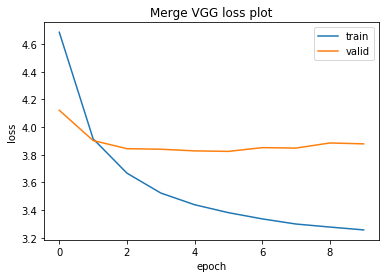

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Merge VGG loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [37]:
# Train model for CapsNet
epochs = 10
train_steps = len(train_desc)
val_steps = len(valid_desc)
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}_CapsNet.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    # create the data generator
train_generator = data_generator(train_desc, train_features, train_tokenizer, max_length, vocab_size)
valid_generator = data_generator(valid_desc, valid_features, train_tokenizer, max_length, vocab_size)
    # fit for one epoch
history = model.fit_generator(train_generator, epochs=epochs, steps_per_epoch=train_steps, verbose=1, validation_data=valid_generator,\
                    validation_steps=val_steps, callbacks=[checkpoint])

Epoch 1/10
6400/6400 [==============================] - 526s 82ms/step - loss: 4.5899 - val_loss: 4.0731

Epoch 00001: val_loss improved from inf to 4.07309, saving model to model-ep001-loss4.605-val_loss4.073_CapsNet.h5
Epoch 2/10
6400/6400 [==============================] - 522s 82ms/step - loss: 3.8356 - val_loss: 3.9065

Epoch 00002: val_loss improved from 4.07309 to 3.90646, saving model to model-ep002-loss3.849-val_loss3.906_CapsNet.h5
Epoch 3/10
6400/6400 [==============================] - 576s 90ms/step - loss: 3.5732 - val_loss: 3.8604

Epoch 00003: val_loss improved from 3.90646 to 3.86041, saving model to model-ep003-loss3.587-val_loss3.860_CapsNet.h5
Epoch 4/10
6400/6400 [==============================] - 603s 94ms/step - loss: 3.4121 - val_loss: 3.8531

Epoch 00004: val_loss improved from 3.86041 to 3.85309, saving model to model-ep004-loss3.426-val_loss3.853_CapsNet.h5
Epoch 5/10
6400/6400 [==============================] - 600s 94ms/step - loss: 3.2982 - val_loss: 3.8754

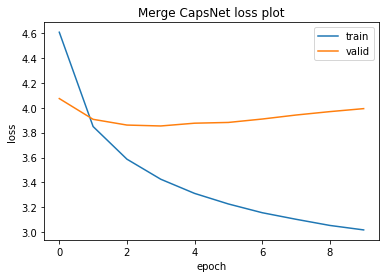

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Merge CapsNet loss plot')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

### Validation using BLEU score

In [19]:
# Import statement to instantiate the models
from utils import model_utils
# Import statements for other calculations
from pickle import load
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu
from numpy import array
from math import log

In [20]:
def generate_desc_beam_search(model, tokenizer, photo, max_length, beam_length=1):
    """
    Description: This function can be used to create description
    :model: The decoder model object
    :tokenizer: The tokenizer object used to get the words from predicted indexes
    :max_length: The maximum length of the sentence to be generated
    :beam_length: Length to check conditional probability. 
                1: for greedy search
                1+: For beam search
    """
    in_text = 'startseq'
    beam_list = list()
    for i in range(max_length):
        if not beam_list:
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([photo,sequence], verbose=0).squeeze()
            yhat_idx = yhat.argsort()[-beam_length:]
            for idx in yhat_idx:
                word = tokenizer.index_word[idx]
                in_text += ' ' + word
                beam_list.append((in_text, log(yhat[idx])))
        else:
            combination_list = list()
            for elems in beam_list:
                if elems[0].endswith('endseq'):
                    combination_list.append(elems)
                    continue
                in_text = elems[0]
                sequence = tokenizer.texts_to_sequences([in_text])[0]
                sequence = pad_sequences([sequence], maxlen=max_length)
                yhat = model.predict([photo,sequence], verbose=0).squeeze()
                yhat_idx = yhat.argsort()[-beam_length:]
                for idx in yhat_idx:
                    word = tokenizer.index_word[idx]
                    if word is None:
                        continue
                    in_text += ' ' + word
                    combination_list.append((in_text, elems[1]*log(yhat[idx])))
            probs = array([combinations[1] for combinations in combination_list])
            top_idx = probs.argsort()[-beam_length:]
            for i, idx in enumerate(top_idx):
                beam_list[i] = combination_list[idx]
    probs = array([prob[1] for prob in beam_list])
    top_idx = argmax(probs)        
    return beam_list[top_idx][0]

In [21]:
def get_BLEU(model, test_desc, photo_feature, tokenizer, max_length, beam_length=1):
    """
    Decription: This function can be used to evaluate BLEU score of the model word by word
    :model: The Decoder model
    :test_desc: test description
    :photo_feature: Extracted features of photos
    :tokenizer: Tokenizer object
    :max_length: Maximum length of the expected sentence
    :beam_length: Beam Length for beam search
    """
    actual, predicted = list(), list()
    count = 0
    for key, desc_list in test_desc.items():
        yhat = generate_desc_beam_search(model, tokenizer, photo_feature[key], max_length, beam_length)
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

### BLEU Score on the extracted features by VGG16

In [22]:
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
features = 'features_vgg.pkl'
all_features = load(open(features, 'rb'))
test_features = {image_id:feat for image_id, feat in all_features.items() if image_id in test_set}
test_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in test_set}

In [23]:
### Get the BLEU score VGG extracted features with beam length 1
vgg_decoder_path = "model-ep006-loss3.382-val_loss3.825_VGG.h5"
test_model = load_model(vgg_decoder_path)
beam_length = 1
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.534923
BLEU-2: 0.286939
BLEU-3: 0.196144
BLEU-4: 0.091162


In [24]:
# Beam length 2
beam_length = 2
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.351184
BLEU-2: 0.127337
BLEU-3: 0.056491
BLEU-4: 0.014168


### BLEU Score on the extracted features by Capsule Network

In [39]:
features = 'features_capsnet.pkl'
all_features = load(open(features, 'rb'))
test_features = {image_id:feat for image_id, feat in all_features.items() if image_id in test_set}
test_desc = {image_id:desc for image_id, desc in descriptions.items() if image_id in test_set}
capsnet_decoder_path = "model-ep004-loss3.426-val_loss3.853_CapsNet.h5"
beam_length = 1
test_model = load_model(capsnet_decoder_path)
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.535765
BLEU-2: 0.267472
BLEU-3: 0.177909
BLEU-4: 0.087625


In [40]:
# Beam length 2
beam_length = 2
get_BLEU(test_model, test_desc, test_features, tokenizer, max_length, beam_length)

BLEU-1: 0.335305
BLEU-2: 0.106694
BLEU-3: 0.040855
BLEU-4: 0.006679


### Inference

In [1]:
def extract_feature(model, arch, image_path):
    """
    Description: Extract features for a given image
    :model: The Encoder model
    :arch: The arch type
    :image_path: Path to the image
    """
    feature = None
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    target_size = (64,64) if arch=='capsnet' else (224,224)
    try:
        image = load_img(image_path, target_size=target_size)
    except Exception as e:
        print('{} could not be opened. Skipping\n {}'.format(image_path,e))
        return None
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    if arch=='capsnet':
        feature = model.predict(image, verbose=0).reshape(-1, 10*32)
    else:
        image = preprocess_input(image)
        feature = model.predict(image, verbose=0)
    return feature

In [ ]:
arch = 'capsnet'
encoder_model = initiate_encoder(arch)
# Extract features of the image
image_path = r'C:\Users\jayde\OneDrive\Desktop\247778426_fd59734130.jpg'
photo_feature = extract_feature(encoder_model, arch, image_path)
max_length = 34
# Load the tokenizer model
tokenizer = load(open('tokenizer.pkl', 'rb'))
# Load the decoder model
decoder_path = r''
test_model = load_model(decoder_path)
# Beam Search length
beam_length = 1
print(generate_desc_beam_search(test_model, tokenizer, photo_feature, max_length, beam_length))